# Проект - прогнозирование оттока клиентов 

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Первая часть. Исследование

## Загрузка данных 

In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool
import catboost as cat
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

import phik

RND = 311022

In [2]:
try:
    contract = pd.read_csv('./contract.csv')
    internet = pd.read_csv('./internet.csv')
    personal = pd.read_csv('./personal.csv')
    phone = pd.read_csv('./phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
df_all = [contract,internet,personal,phone]
for value in df_all:
    value.info()
    display(value.sample(5))
    display(value.describe(include='all'))
    print('Количество пропусков',value.isna().sum())
    print('------------')
    print('Количество дубликатов =',len(value[value.duplicated()]))
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5224,9233-PSYHO,2016-05-01,No,One year,Yes,Bank transfer (automatic),100.15,4459.8
2940,6313-GIDIT,2015-06-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,54.45,2854.55
5503,1757-TCATG,2017-03-01,No,One year,No,Bank transfer (automatic),20.05,746.75
4887,9184-GALIL,2016-12-01,No,Month-to-month,No,Mailed check,20.45,781.25
3820,9481-IEBZY,2014-02-01,No,Month-to-month,Yes,Credit card (automatic),112.90,8061.5


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Количество пропусков customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
------------
Количество дубликатов = 0
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
762,4208-UFFGW,DSL,No,No,No,No,No,No
187,9903-LYSAB,Fiber optic,No,No,No,No,No,No
587,1173-NOEYG,Fiber optic,No,No,Yes,No,No,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No
3514,6178-KFNHS,Fiber optic,Yes,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Количество пропусков customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
------------
Количество дубликатов = 0
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
4984,5236-XMZJY,Female,0,No,No
3418,4176-FXYBO,Male,0,Yes,No
3484,2921-XWDJH,Female,1,Yes,No
13,0280-XJGEX,Male,0,No,No
424,8111-BKVDS,Female,0,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


Количество пропусков customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
------------
Количество дубликатов = 0
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
3570,6339-TBELP,Yes
3726,3345-PBBFH,No
1429,3070-FNFZQ,No
4835,3143-JQEGI,No
4827,1448-CYWKC,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Количество пропусков customerID       0
MultipleLines    0
dtype: int64
------------
Количество дубликатов = 0
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


In [4]:
contract['TotalCharges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

In [5]:
contract[contract['TotalCharges'] == " "]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


### Вывод:

У нас есть 4 датасета
- `contract.csv` — информация о договоре - 8 столбцов и 7043 строки
- `personal.csv` — персональные данные клиента - 8 столбцов и 5517 строки
- `internet.csv` — информация об интернет-услугах - 5 столбцов и 7043 строки
- `phone.csv` — информация об услугах телефонии. - 2 столбца и 6361 строки

Разное количество строк связано с тем, что у каждого клиента свой набор услуг.

Пропусков в данных нет. EndDate - No - означает, что клиент еще пользуется услугами оператора.

Целевой признак будем брать из столбца EndDate, 1 если есть дата и 0 если нет.

Признаки:
  - Type – тип оплаты: ежемесячный, годовой и тд,
  - PaperlessBilling – электронный документ об оплате,
  - PaymentMethod – способ оплаты,
  - MonthlyCharges – ежемесячные траты на услуги,
  - TotalCharges – всего потрачено денег на услуги
  - InternetService - какой интернет     
  - OnlineSecurity - блокировка небезопасных сайтов      
  - OnlineBackup - облачное хранилище файлов для резервного копирования данных        
  - DeviceProtection - наличие антивируса   
  - TechSupport - выделенная линия технической поддержки         
  - StreamingTV - стриминговое телевидение          
  - StreamingMovies - каталог фильмов     
  - Dependents – наличие иждивенцев
  - Senior Citizen – наличие пенсионного статуса по возрасту
  - Partner – наличие супруга(и)
  - gender - пол
  - MultipleLines – наличие возможности ведения параллельных линий во время звонка

Добавим признак продолжительность пользования услугами (вычтим из EndDate BeginDate) если нет даты, воспользуемся условием задачи "Информация о договорах актуальна на 1 февраля 2020."

Дубликатов нет.

У 11 клиентов отсутствуют значения в графе "TotalCharges – всего потрачено денег на услуги", это связано с тем что 1 день даты начала пользования услуги совпадает с последним днем днем в наших данных, видимо платеж еще не прошел. Думаю имеет смысл, просто удалить данные строки, учитывая что потеря данных составят менее 1%. 

Необходимо будет заменить тип данных в столбцах с датой.

## Анализ и подготовка данных

- Обьеденим данные
- выделим целевой признак
- создадим дополнительный признак - продолжительнось пользования услугой
- удалим сталбцы с датами
- разделим данные на тренировочную и тестовую выборку в соотношении 75% к 25%

Cоздаем целевой признак на основе столбца EndDate: если Target = 1, значит что клиент от нас ушел, иначе Target = 0

In [6]:
contract['Target'] = 1
contract.loc[contract['EndDate'] == 'No', 'Target'] = 0

Меняем формат сталбцов с датами

In [7]:
contract[contract['EndDate'] == '2020-02-01 00:00:00']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target


In [8]:
contract['EndDate']= contract['EndDate'].replace('No', '2020-02-01 00:00:00')

contract['BeginDate']= pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')

Рост клиентов по годам

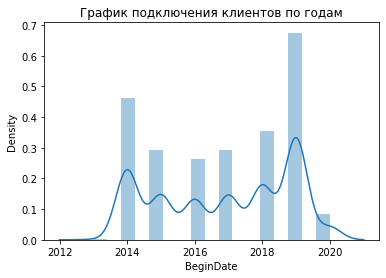

In [9]:
plt.title("График подключения клиентов по годам")
sns.distplot(contract['BeginDate'].dt.year);

Отток клиентов по годам

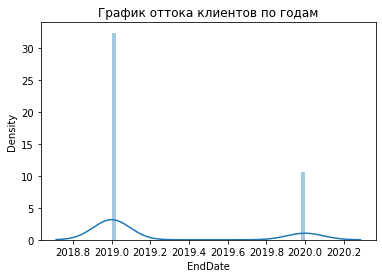

In [10]:
year_end = contract[contract['EndDate'] < '2020-02-01']

plt.title("График оттока клиентов по годам")
sns.distplot(year_end['EndDate'].dt.year);

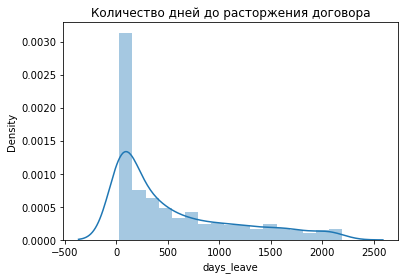

In [11]:
contract['days_leave'] = contract['EndDate'] - contract['BeginDate']

plt.title("Количество дней до расторжения договора")
sns.distplot(contract[contract['EndDate'] != '2020-02-01']['days_leave'].dt.days);

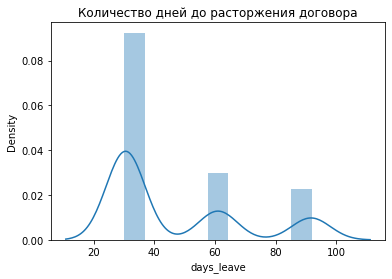

In [12]:
plt.title("Количество дней до расторжения договора")
sns.distplot(contract[(contract['EndDate'] != '2020-02-01') & (contract['days_leave'].dt.days < 120)]['days_leave'].dt.days);

#### Видим что есть, как пики роста клиента в 2014 и 2019 гадах, так и пики оттока в 2019 и 2020 году.

Создадим дополнительный признак - количество дней пользования услугой. 

In [13]:
contract['TotalDays'] = (contract['EndDate'] - contract['BeginDate']).dt.days

Удалим 11 строк, где клиенты, только подключились и не известно какие у них будут траты в этом месяце.

In [14]:
contract['TotalCharges'] = contract['TotalCharges'].replace({" ": np.nan}).astype(float)
contract = contract.dropna()

Объединяем данные в один датафрейм

In [15]:
#до обьеденения удалим лишние столбцы
contract = contract.drop(['EndDate', 'BeginDate','days_leave'], axis=1) 

data = contract.merge(personal, on='customerID', how='left')
data = data.merge(phone, on='customerID', how='left')
data = data.merge(internet, on='customerID', how='left')

In [16]:
data = data.set_index('customerID')

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   Target            7032 non-null   int64  
 6   TotalDays         7032 non-null   int64  
 7   gender            7032 non-null   object 
 8   SeniorCitizen     7032 non-null   int64  
 9   Partner           7032 non-null   object 
 10  Dependents        7032 non-null   object 
 11  MultipleLines     6352 non-null   object 
 12  InternetService   5512 non-null   object 
 13  OnlineSecurity    5512 non-null   object 
 14  OnlineBackup      5512 non-null   object 
 15  DeviceProtection  5512 non-null   object 
 16  TechSupport       5512 non-null 

После обьединение появилось много пропусков, так как есть клиенты, которые пользуются разными наборами услуг, заменим эти значения на No, и только в MultipleLines на NA, чтобы осталось понимание сколько клиентов не пользуются телефонией.

In [18]:
data['MultipleLines'] = data['MultipleLines'].fillna('NA')

In [19]:
data = data.fillna('No')

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   Target            7032 non-null   int64  
 6   TotalDays         7032 non-null   int64  
 7   gender            7032 non-null   object 
 8   SeniorCitizen     7032 non-null   int64  
 9   Partner           7032 non-null   object 
 10  Dependents        7032 non-null   object 
 11  MultipleLines     7032 non-null   object 
 12  InternetService   7032 non-null   object 
 13  OnlineSecurity    7032 non-null   object 
 14  OnlineBackup      7032 non-null   object 
 15  DeviceProtection  7032 non-null   object 
 16  TechSupport       7032 non-null 

### Проведем анализ данных и посмотрим корреляцию признаков:


In [21]:
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,TotalDays,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Female,0,Yes,No,NA,DSL,No,Yes,No,No,No,No
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,Male,0,No,No,NA,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [22]:
def pie_plot(df, name):
    counts = df.value_counts(dropna=False)
    counts.plot.pie(legend=True, labeldistance=1.2, autopct='%1.2f%%', figsize=(20,6), title=name)
    plt.show()

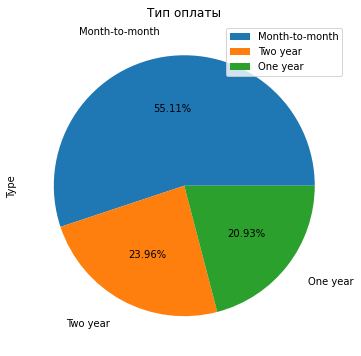

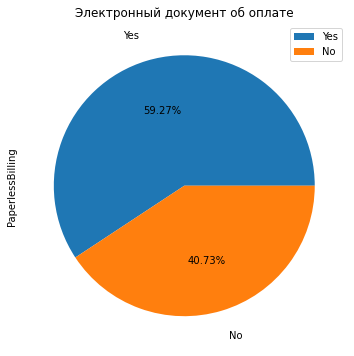

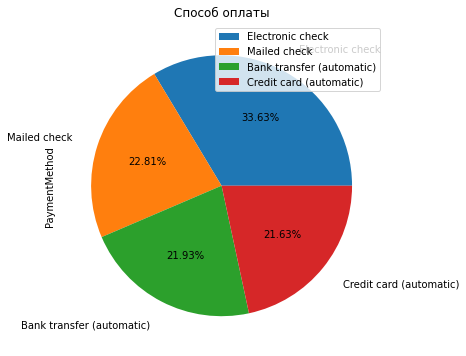

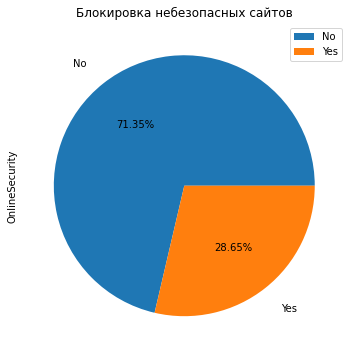

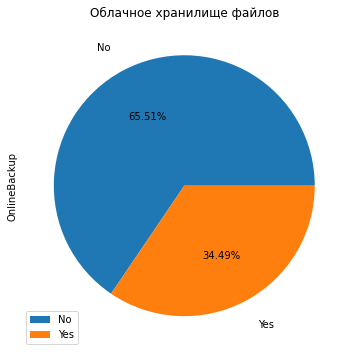

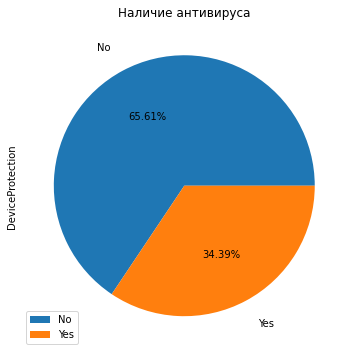

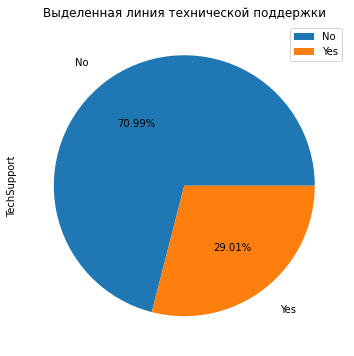

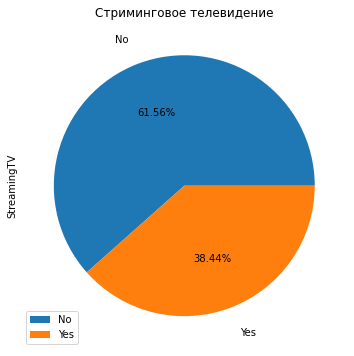

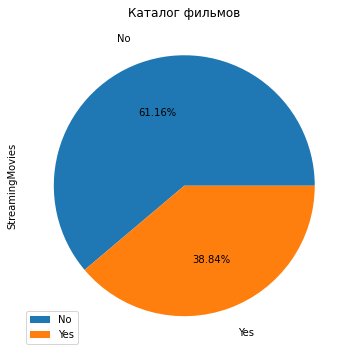

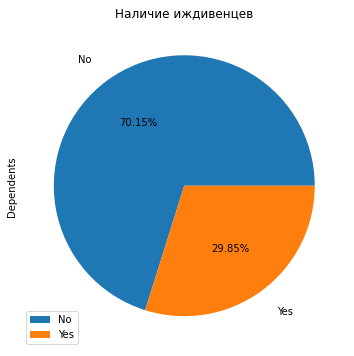

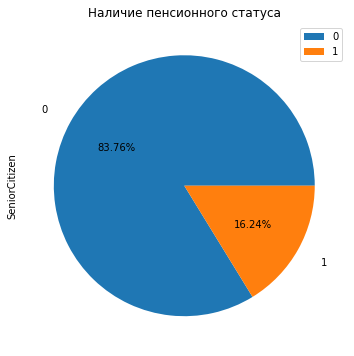

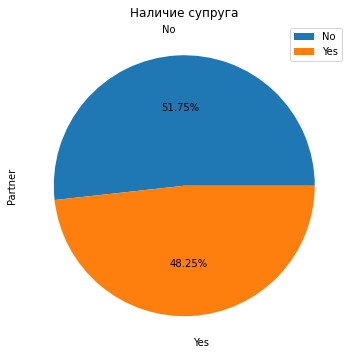

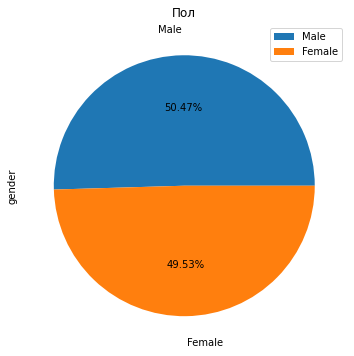

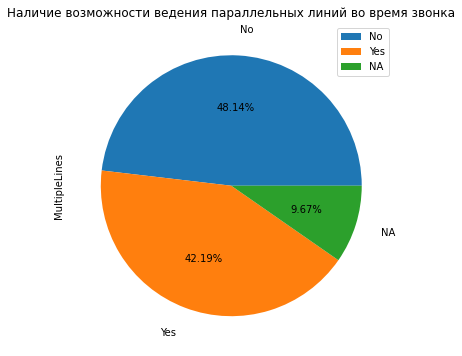

In [23]:
plot = [('Type','Тип оплаты'),
        ('PaperlessBilling','Электронный документ об оплате'),
        ('PaymentMethod','Способ оплаты'),
        ('OnlineSecurity', 'Блокировка небезопасных сайтов'),
        ('OnlineBackup', 'Облачное хранилище файлов'),
        ('DeviceProtection', 'Наличие антивируса'),
        ('TechSupport', 'Выделенная линия технической поддержки'),
        ('StreamingTV', 'Стриминговое телевидение'),
        ('StreamingMovies', 'Каталог фильмов'),
        ('Dependents', 'Наличие иждивенцев'),
        ('SeniorCitizen', 'Наличие пенсионного статуса'),
        ('Partner', 'Наличие супруга'),
        ('gender', 'Пол'),
        ('MultipleLines', 'Наличие возможности ведения параллельных линий во время звонка')]
 
for x in plot:
    pie_plot(data[x[0]],x[1])

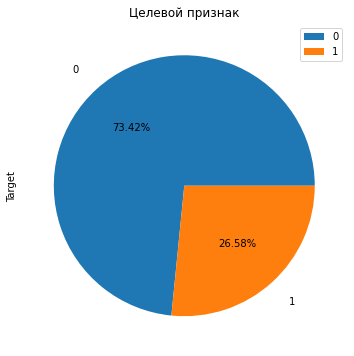

In [24]:
pie_plot(data['Target'], 'Целевой признак')

#### Портрет типичного пользователя: мужчина или женщина, не пенсионер, без иждевенцев, оплачивает услуги ежемесячно,предпочитает получать электронные чеки.

Посмотрим, сколько клинтов и какими услугами пользуются:

In [25]:
data['Services'] = 0 # Клиент использует и интернет и телефонию
data.loc[data['MultipleLines'] == 'NA', 'Services'] = 1 # Только интернет
data.loc[data['InternetService'] == 'No', 'Services'] = 2 # Только телефония

In [26]:
data['Services'].value_counts()

0    4832
2    1520
1     680
Name: Services, dtype: int64

In [27]:
data[data['Target'] == 1]['Services'].value_counts()

0    1586
1     170
2     113
Name: Services, dtype: int64

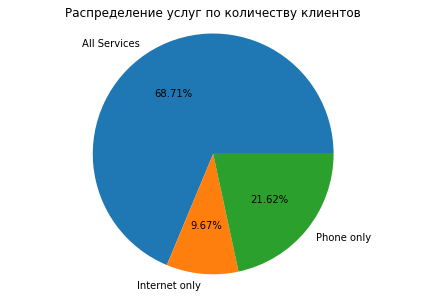

In [28]:
labels = ['All Services', 'Internet only', 'Phone only']
sizes = data['Services'].value_counts().sort_index().values
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.2f%%')

ax1.axis('equal')  
plt.tight_layout()
plt.title("Распределение услуг по количеству клиентов")
plt.show()

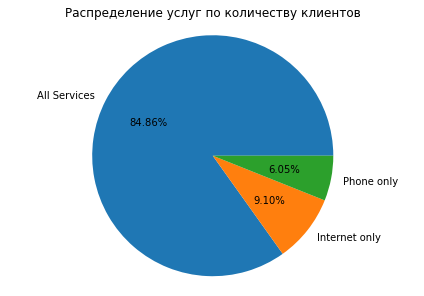

In [29]:
labels = ['All Services', 'Internet only', 'Phone only']
data_out = data.query('Target == 1')
sizes = data_out['Services'].value_counts().values
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.2f%%')

ax1.axis('equal')  
plt.tight_layout()
plt.title("Распределение услуг по количеству клиентов")
plt.show()

Сравнив 2 графика, делаю вывод, что нет зависимости от определенной услуги и оттока клиентов.

<AxesSubplot:>

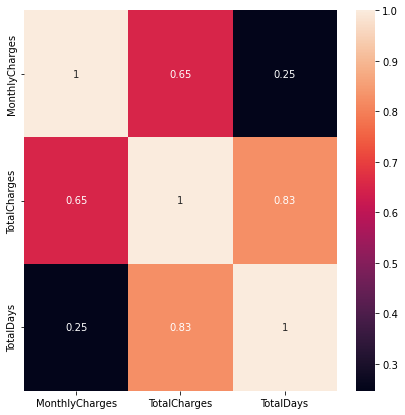

In [30]:
corr_data = data.drop(['Target','SeniorCitizen','Services'], axis = 1)
corrMatrix = corr_data.corr()
plt.figure(figsize=(7, 7))
sns.heatmap(corrMatrix, annot=True)

Есть сильная корреляция между TotalCharges и TotalDays, оставим в выборке только один из них.

Так же уберем признак gender и Services.

In [31]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'TotalDays', 'Services']
corr = data.phik_matrix(interval_cols=interval_cols)

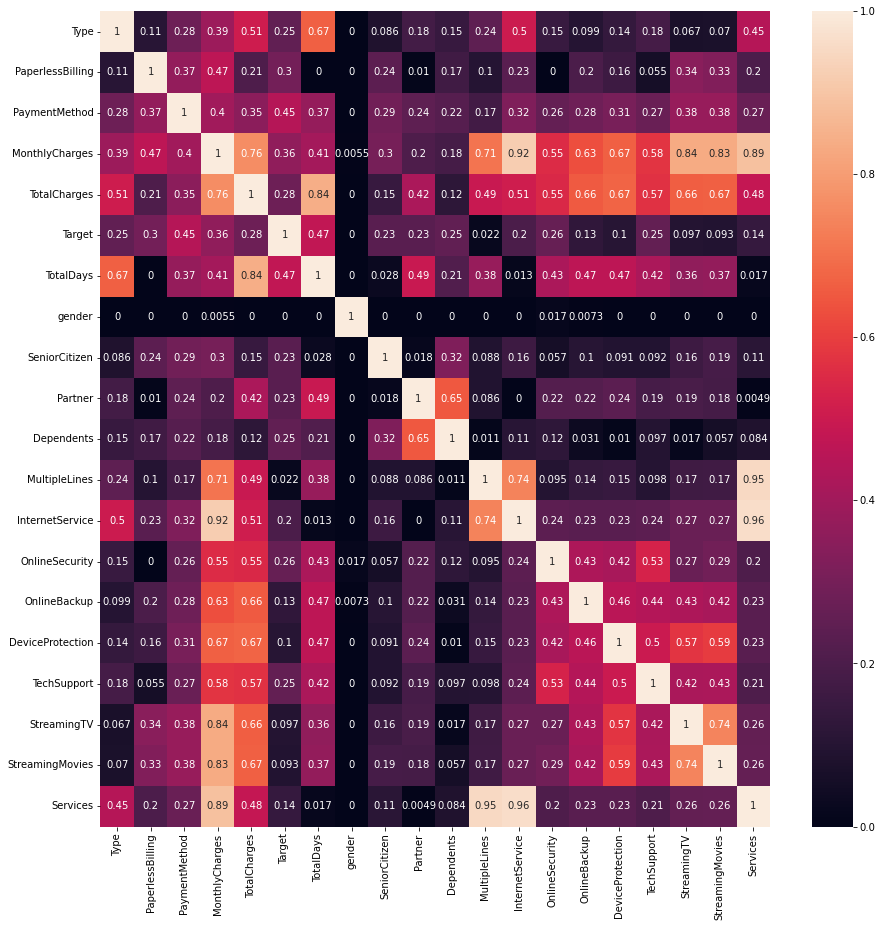

In [32]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True);

In [33]:
data = data.drop(['gender','TotalCharges'], axis=1)

Разделим датасет на тренировочную и тестовые выборки:

In [34]:
train_df, test_df = train_test_split(data, test_size = 0.25, random_state = RND)

In [35]:
features_train = train_df.drop('Target', axis = 1)
features_test = test_df.drop('Target', axis = 1)

target_train = train_df['Target']
target_test = test_df['Target']

In [36]:
cat_cols = ['Type','InternetService','MultipleLines','PaymentMethod','Dependents','Partner','StreamingMovies',
            'StreamingTV','TechSupport','DeviceProtection','OnlineBackup','OnlineSecurity','PaperlessBilling']

# Вторая часть. Обучение моделей

Обучим несколько моделей для сравнения, возьмем catboost и LGBM.

#### CatBoostClassifier

In [37]:
def model_grid(model, parameters):

    model_grid = GridSearchCV(model, parameters, cv=5, scoring='roc_auc', refit=True)
    model_grid.fit(features_train, target_train)
    return model_grid.best_score_, model_grid.best_params_, model_grid.best_estimator_

In [38]:
%%time

parameters = { 'iterations': [400,600,1000],
               'learning_rate' : [0.01,0.03],
               #'depth' : range(3,15,3),
               'verbose' : [False], 
               'random_state': [RND]}
model_cat = CatBoostClassifier(eval_metric='AUC',
                               auto_class_weights='Balanced',
                               grow_policy = 'Lossguide',
                               cat_features=cat_cols)

roc_auc, best_parameters, best_model_cat = model_grid(model_cat, parameters)

display('CatBoostClassifier:', best_parameters)
display('roc_auc:', roc_auc)
display('best_model_cat', best_model_cat)

catPrediction_Proba = best_model_cat.predict_proba(features_train)[:,1]
cat_roc = roc_auc_score(target_train, catPrediction_Proba)
cat_roc


'CatBoostClassifier:'

{'iterations': 1000,
 'learning_rate': 0.03,
 'random_state': 311022,
 'verbose': False}

'roc_auc:'

0.9163488895103125

'best_model_cat'

CPU times: user 9min 16s, sys: 34.1 s, total: 9min 50s
Wall time: 1min 51s


0.9901109807780736

In [39]:
best_model_cat


In [40]:
results = pd.DataFrame({'model':type(model_cat).__name__, 'best_parameters':[best_parameters], 'roc_auc':roc_auc})
results

,model,best_parameters,roc_auc
0,CatBoostClassifier,"{'iterations': 1000, 'learning_rate': 0.03, 'r...",0.916349


#### LGBMClassifier

In [41]:
for c in cat_cols:
    features_train[c] = features_train[c].astype('category')

In [42]:
%%time

parameters = {'n_estimators': [100, 500],
        'learning_rate':[x/10 for x in range(1, 3)],
        'random_state' :[RND]     
        }
roc_auc, best_parameters, best_model_lgbm = model_grid(LGBMClassifier(class_weight='balanced',metric ='auc',min_child_samples = 10,
                                                     objective='binary',reg_alpha = 0), parameters)
display('LGBMClassifier:', best_parameters)
display('roc_auc:', roc_auc)
display('best_model_lgbm',best_model_lgbm)

'LGBMClassifier:'

{'learning_rate': 0.2, 'n_estimators': 100, 'random_state': 311022}

'roc_auc:'

0.9057381992140744

'best_model_lgbm'

LGBMClassifier(class_weight='balanced', learning_rate=0.2, metric='auc',
               min_child_samples=10, objective='binary', random_state=311022,
               reg_alpha=0)

CPU times: user 1min 6s, sys: 3.15 s, total: 1min 9s
Wall time: 11.4 s


In [43]:
best_model_lgbm

LGBMClassifier(class_weight='balanced', learning_rate=0.2, metric='auc',
               min_child_samples=10, objective='binary', random_state=311022,
               reg_alpha=0)

In [44]:
results = results.append({'model':type(best_model_lgbm).__name__, 'best_parameters':best_parameters, 'roc_auc':roc_auc}, ignore_index=True)
results

,model,best_parameters,roc_auc
0,CatBoostClassifier,"{'iterations': 1000, 'learning_rate': 0.03, 'r...",0.916349
1,LGBMClassifier,"{'learning_rate': 0.2, 'n_estimators': 100, 'r...",0.905738


#### Тестирование

In [45]:
model_cat = CatBoostClassifier( iterations = 1000,
                                random_state = RND,
                                eval_metric='AUC',
                                auto_class_weights='Balanced',
                                grow_policy = 'Lossguide',
                                verbose=False,
                                cat_features=cat_cols,
                                learning_rate = 0.03).fit(features_train,target_train)

In [46]:
model_cat.fit(features_train, target_train)

In [47]:
catPrediction_Proba = model_cat.predict_proba(features_test)[:,1]
cat_roc = roc_auc_score(target_test, catPrediction_Proba)
cat_roc

0.9263894175061108

In [48]:
catPrediction = model_cat.predict(features_test)
cat_accuracy = accuracy_score(target_test,catPrediction)
cat_accuracy

0.8623435722411832

# Вывод

Исходные данные состояли из 4 таблиц с информацией о договоре (дата подключения, дата прекращения пользовани услугами, сумм затрат на ежемесячные платежи и общих сумм затрат клиента), персональных данных о клиентах, сведения об услугах интрернета, телефонии и доп. услугах. 

Цель исследования создать модель, которая на основании имеющихся даннных будет предсказывать уход клиента от компании. Целевой метрикой оценки точности предсказания модели считатется AUC-ROC

В ходе работы над проектом придерживалась намеченного плана и было выполнено следующее:

Внимательно изучила техническое задание, провёла первичный анализ.

Полученные данные проанализированны:
    
- данные загружены;
- в данных выявила недостатки, пути их решения и возможные причины их возникновения:
  - Добавила признак продолжительность пользования услугами (вычтим из EndDate BeginDate) если нет даты, воспользуемся условием задачи "Информация о договорах актуальна на 1 февраля 2020."
  - У 11 клиентов отсутствуют значения в графе "TotalCharges – всего потрачено денег на услуги", это связано с тем что 1 день даты начала пользования услуги совпадает с последним днем днем в наших данных, видимо платеж еще не прошел. Думаю имеет смысл, просто удалить данные строки, учитывая что потеря данных составят менее 1%.
  - Необходимо заменить тип данных в столбцах с датой.
- проверила наличие дубликатов - они отсутствовали;

По предобработке данных проведены следующие действия:

- ввела несколько новых признаков для анализа
  - целевой признак Target, указывающий на статус клиента
  - TotalDays - количество дней пользования услугой
  - Services - для анализа клиентов с точки зрения использования основных услуг, интернет/телефония/все вместе.  
  - days_leave - для построения графиков "количество дней до расторжения договора"
- все датасеты объединила в один датасет для удобства работы
  - после обьединения появилось много пропусков, так как есть клиенты, которые пользуются разными наборами услуг, заменим эти значения на No, и только в MultipleLines на NA, чтобы осталось понимание сколько клиентов не пользуются телефонией.
- исправила недостатки в данных, определенных на предыдущем этапе
  - поменяла формат сталбцов с датами
- исправлила найденые аномалий
  - удалила 11 строк с пустыми значениями в поле TotalCharges (это новые абоненты, с датой подключения соответствующей дате выгрузки)
  - удалила столбцы с датами, чтобы не произошла утечка
  - использовала идентификаторы как индексы

Исследовательский анализ данных:

- Построены графики
  - Рост клиентов по годам
  - Отток клиентов по годам
  - Количество дней до расторжения договора

Вывод: В основном клиенты рассторгают договор в первый месяц использования. Информация для заказчика: может при подключение клиент получал, какой-нибудь бонус, получив его отключался, это то что надо изучить, но нужно больше данных.

- Построены графики распределения количество пользоватей по различным признакам
  - Портрет типичного пользователя: мужчина или женщина, не пенсионер, без иждевенцев, оплачивает услуги ежемесячно,предпочитает получать электронные чеки.
- Построен график распределения целевого признака
  - Изучив распределение ответов в целевом признаке, можем сделать вывод о дисбалансе классов (3 к 1), учтем это при обучении моделей
- Построен график "Распределение основных услуг (телефония/интернет/все вместе) по количеству клиентов всего/ушедших
  - телефония очень качественная услуга, ведь из 1520 абонентов только телефонии ушли всего 113 клиентов, что составило всего 7%, в то время как абонентов использующих только интернет ушло 25%, самый большой отток в категории клиентов у которых был и интерент и телефония 33%
- определила зависимости между различными признаками (провела графический анализ на мультиколлениарность)
  - gender - коэффициент корреляции 0, от него ни чего не зависит, только увеличит время обучения
  - Services, TotalCharges, TotalDays могли привести к мультиколлинеарности, удалила Services и TotalCharges

Подготовка данных к расчету модели:

- Данные разделила на две выборки: тренировочную и тестовую

Моделирование:

- Используя GridSearchCV обучила и подобрала оптимальные параметры для 2х моделей
  - CatBoostClassifier
  - LGBMClassifier
- построила сводную таблицу моделей и полученных метрик;

Тестирование модели:

- Лучшую модель протестировала на тестовой выборке

CatBoostClassifier - AUC-ROC = 0.9263

- дополнительно вычислена метрика accuracy

accuracy = 0.8623


---

Описание модели: алгоритм, метрики качества, гиперпараметры

CatBoostClassifier 
- {'depth': 9, 'iterations': 1000, 'learning_rate': 0.03, 'random_state': 311022, 'verbose': False}
- AUC-ROC = 0.9236
- accuracy = 0.8623